In [1]:
# !pip install tensorflow tensorflow-metal opencv-python
# !pip list

In [2]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import cv2, imghdr

In [5]:
data_dir = 'data'
image_exts = ['jpg', 'png', 'jpeg', 'bmp']

In [6]:
for result in os.listdir(data_dir):
    if result == '.DS_Store' : continue
    for image in os.listdir(os.path.join(data_dir, result)):
        try: 
            image_array = cv2.imread(os.path.join(data_dir, result, image))
            image_ext = imghdr.what(os.path.join(data_dir, result, image))
            if image_ext not in image_exts:
                os.remove(os.path.join(data_dir, result, image))
        except Exception as e:
            print(os.path.join(data_dir, result, image), " ", e )

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()

Found 250 files belonging to 2 classes.


2025-01-03 12:18:28.498243: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-01-03 12:18:28.498278: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-03 12:18:28.498281: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-03 12:18:28.498321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-03 12:18:28.498343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
batch = data_iterator.next()

In [9]:
batch[0].shape

(32, 256, 256, 3)

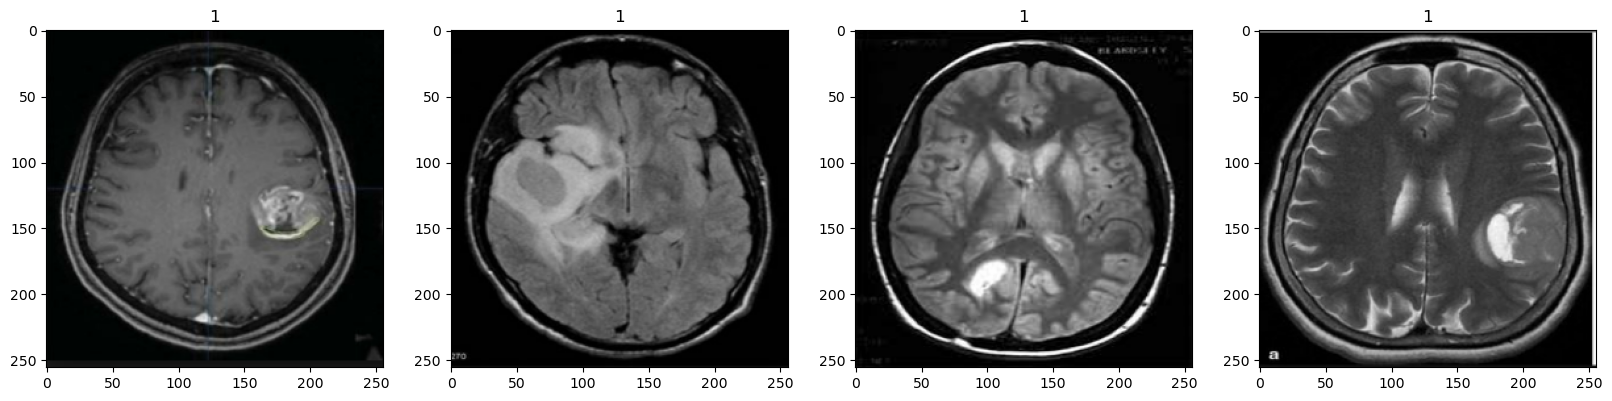

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 1 : Have brain tumor
## 0 : Don't have brain tumor

In [11]:
len(data)

8

In [12]:
data = data.shuffle(data.cardinality())
data = data.map(lambda x, y : (x/225, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


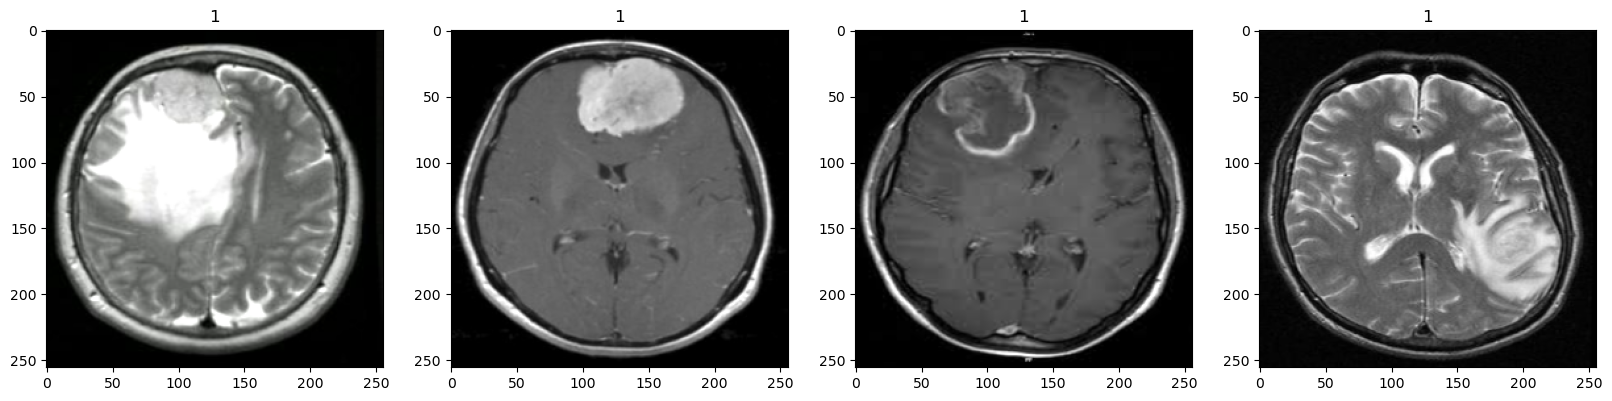

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 5 batches for training
## 2 batches for validation
## 1 batch for testing 

In [14]:
train_count = 5
val_count = 3
test_count = 1

In [15]:
train = data.take(train_count)
val = data.skip(train_count).take(val_count)
test = data.skip(val_count).take(test_count)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [17]:
model = Sequential()

In [18]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

In [20]:
logdir = 'logs'
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorflow_callback])

Epoch 1/20


2025-01-03 12:18:29.927234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.5688

2025-01-03 12:18:30.521048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 106ms/step - loss: 0.6462 - accuracy: 0.5688 - val_loss: 0.6356 - val_accuracy: 0.6354
Epoch 2/20
5/5 [==============================] - 1s 118ms/step - loss: 0.5735 - accuracy: 0.7013 - val_loss: 0.4373 - val_accuracy: 0.8444
Epoch 3/20
5/5 [==============================] - 0s 76ms/step - loss: 0.5037 - accuracy: 0.7922 - val_loss: 0.4890 - val_accuracy: 0.7708
Epoch 4/20
5/5 [==============================] - 0s 75ms/step - loss: 0.4680 - accuracy: 0.8052 - val_loss: 0.5069 - val_accuracy: 0.7708
Epoch 5/20
5/5 [==============================] - 0s 73ms/step - loss: 0.4536 - accuracy: 0.8312 - val_loss: 0.4156 - val_accuracy: 0.8542
Epoch 6/20
5/5 [==============================] - 0s 76ms/step - loss: 0.4809 - accuracy: 0.8062 - val_loss: 0.4214 - val_accuracy: 0.8333
Epoch 7/20
5/5 [==============================] - 0s 73ms/step - loss: 0.4200 - accuracy: 0.8247 - val_loss: 0.4396 - val_accuracy: 0.8125
Epoch 8/20
5/5 [====================

In [22]:
hist.history

{'loss': [0.6462336778640747,
  0.5735248923301697,
  0.5037029981613159,
  0.46797481179237366,
  0.4535812735557556,
  0.4808923304080963,
  0.42002734541893005,
  0.4072849154472351,
  0.38819581270217896,
  0.35772258043289185,
  0.32371029257774353,
  0.2655790150165558,
  0.18842150270938873,
  0.2396090179681778,
  0.16473379731178284,
  0.15325120091438293,
  0.15663062036037445,
  0.15266749262809753,
  0.06728862226009369,
  0.07786790281534195],
 'accuracy': [0.5687500238418579,
  0.701298713684082,
  0.7922077775001526,
  0.8051947951316833,
  0.8311688303947449,
  0.8062499761581421,
  0.8246753215789795,
  0.831250011920929,
  0.8181818127632141,
  0.850649356842041,
  0.8636363744735718,
  0.8812500238418579,
  0.9025974273681641,
  0.9025974273681641,
  0.918749988079071,
  0.948051929473877,
  0.9220778942108154,
  0.9375,
  0.9750000238418579,
  0.9750000238418579],
 'val_loss': [0.6355659365653992,
  0.4372883141040802,
  0.4890466034412384,
  0.5069344639778137,
  0

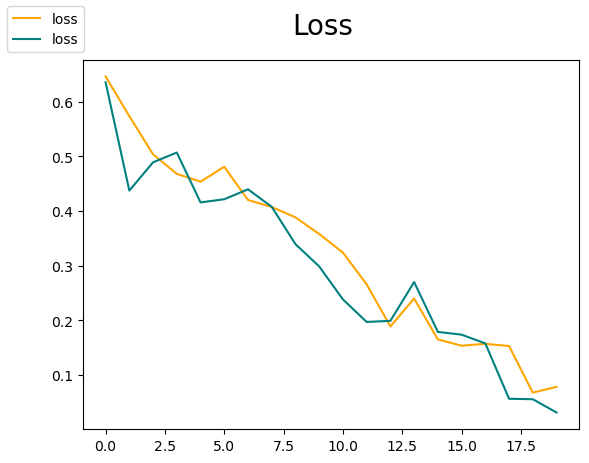

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='orange', label='loss')
plt.plot(hist.history['val_loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
fig.legend(loc='upper left')
plt.show()

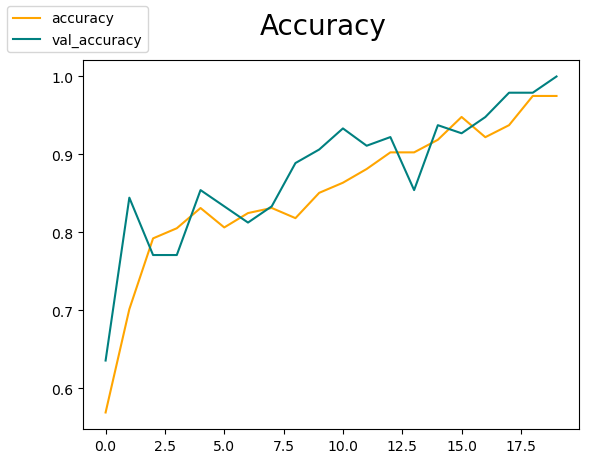

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='teal', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
fig.legend(loc='upper left')
plt.show()

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [26]:
for batch in test.as_numpy_iterator():
    x , y = batch
    y_predict = model.predict(x)
    pre.update_state(y, y_predict)
    re.update_state(y, y_predict)
    acc.update_state(y, y_predict)
print(f'Precision : {pre.result()}, Recall : {re.result()}, Binnary Accuracy : {acc.result()}')

1/1 [==============================] - 0s 66ms/step
Precision : 0.9523809552192688, Recall : 1.0, Binnary Accuracy : 0.96875


2025-01-03 12:18:39.699953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


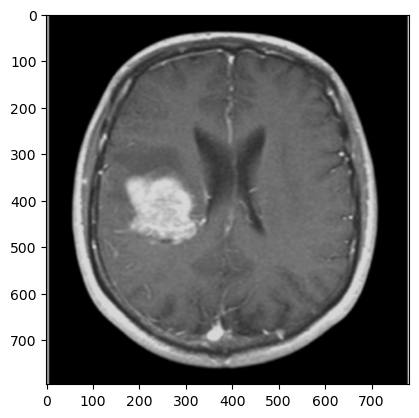

In [27]:
sample_image = os.path.join('/Users/abbazs/Projects/ML-Data-Science/binary_image_classification_brain_tumor_mri_scan', 'tumor_yes_sample.png')
image_bgr = cv2.imread(sample_image)
image_rgb = plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))

In [28]:
model.predict(np.expand_dims(tf.image.resize(image_bgr, (256, 256)), axis = 0)/255)

1/1 [==============================] - 0s 57ms/step


2025-01-03 12:18:39.975827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.9956566]], dtype=float32)

In [29]:
model.save(os.path.join('models', 'braintumor.h5'))

/Users/abbazs/Projects/ML-Data-Science/binary_image_classification_brain_tumor_mri_scan/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
